In [1]:
!nvidia-smi

Fri Oct 14 14:20:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Import all the required libraries


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from PIL import Image

#used for creating Progress Meters or Progress Bars
from tqdm import tqdm


In [3]:
# Install additional libraries required

!pip install -q wordcloud
!pip install -q gtts
!pip install -q playsound

In [4]:
import glob
from gtts import gTTS
from playsound import playsound
from IPython import display

import collections
import wordcloud
from wordcloud import WordCloud, STOPWORDS

import numpy as np
import pandas as pd

import os

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Import the dataset and read the image into a seperate variable

images='drive/MyDrive/datascience/archive/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


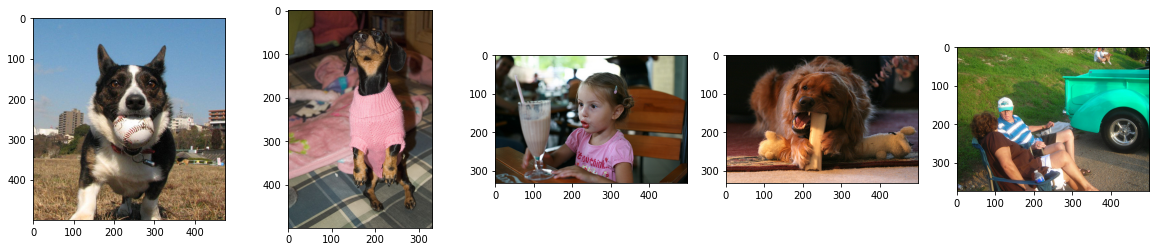

In [7]:
#Visualise both the images & text present in the dataset
import imageio

#Visualising first 5 images :

Display_Images = all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for ax, image in zip(axes, Display_Images):
  ax.imshow(imageio.imread(image), cmap=None)


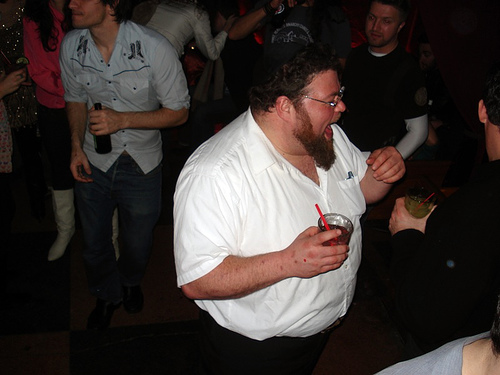

In [8]:
# view a random image

import random
Image.open(all_imgs[random.randrange(40, 60, 3)])

In [9]:
#Import the dataset and read the text file into a separate variable

#txt_file = 'Flickr8K/captions.txt'
text_file = 'drive/MyDrive/datascience/archive/captions.txt'

def load_doc(filename):
    
    #your code here
    open_file = open(text_file, 'r', encoding='latin-1' ) #returns a file object
    text = open_file.read() #reads contents of the file
    open_file.close()
    #print(text)
    
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [10]:
img_path = 'drive/MyDrive/datascience/archive/Images/'

all_img_id = [] #store all the image id here
all_img_vector = [] #store all the image path here
annotations = [] #store all the captions here

with open('drive/MyDrive/datascience/archive/captions.txt' , 'r') as fo:
  next(fo) #to skip the heading
  for line in fo :
    split_arr = line.split(',')
    all_img_id.append(split_arr[0])
    annotations.append(split_arr[1].rstrip('\n.')) #removing out the \n.
    all_img_vector.append(img_path+split_arr[0])

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

ID  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                    Path  \
0      drive/MyDrive/datascience/archive/Images/10002...   
1      drive/MyDrive/datascience/archive/Images/10002...   
2      drive/MyDrive/datascience/archive/Images/10002...   
3      drive/MyDrive/datascience/archive/Images/10002...   
4      drive/MyDrive/datascience/archive/Images/10002...   
...                                                  ...   
40450  drive/MyDrive/datascience/archive/Images/99772...   
40451  drive/MyDrive/datascience/archive/Images/99772...   
40452  drive/MyDrive/datascience/archive/Images/99772...   
40453  drive/MyDrive/datascience/archive/Images/99772...   
40454  drive/MyDrive/datascience/archive/Images/99772...   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                   A girl going into a wooden building   
2        A little girl climbing into a wooden playhouse   
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451            A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock fac...  
40453                     A rock climber in a red shirt   
40454  A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [11]:
len (annotations)

40455

In [12]:
type (annotations)

list

In [13]:
#check total captions and images present in dataset

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_imgs)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [14]:
#Create the vocabulary & the counter for the captions
#lower() used to ensure same count irrespective of an alphabet's case

vocabulary = [word.lower() for line in annotations for word in line.split()]

val_count = Counter(vocabulary) 
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Count')

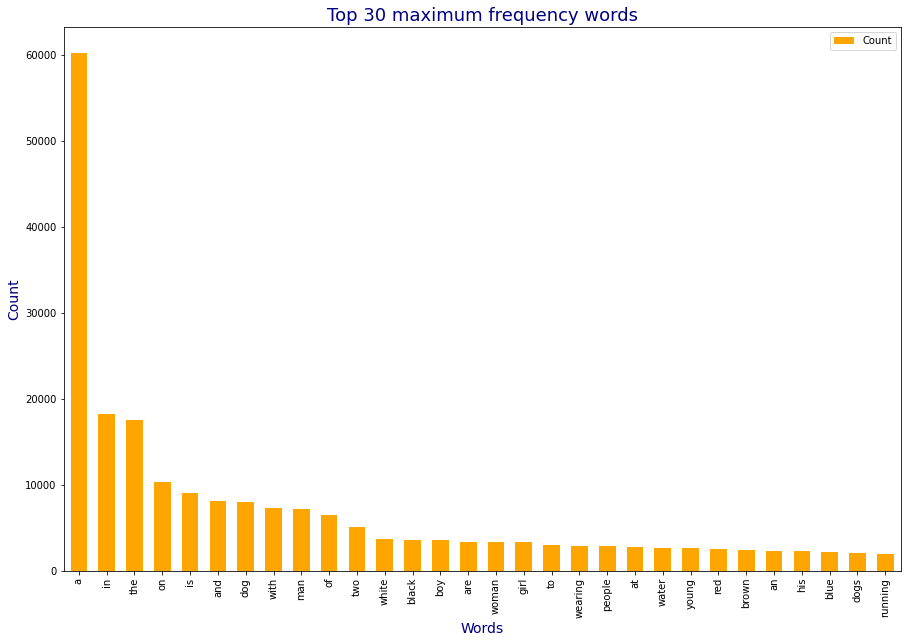

In [15]:
#Visualise the top 30 occuring words in the captions

#write your code here
for word, count in val_count.most_common(30):
  print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word', y='Count', width=0.6, color='orange', figsize=(15, 10))
plt.title("Top 30 maximum frequency words", fontsize = 18, color= 'navy')
plt.xlabel("Words", fontsize = 14, color= 'navy')
plt.ylabel("Count", fontsize = 14, color= 'navy')


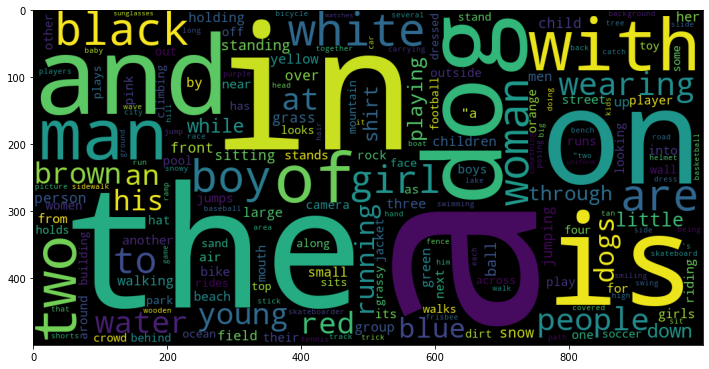

In [16]:
## check out the top 30 stopwords with higher frequency

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

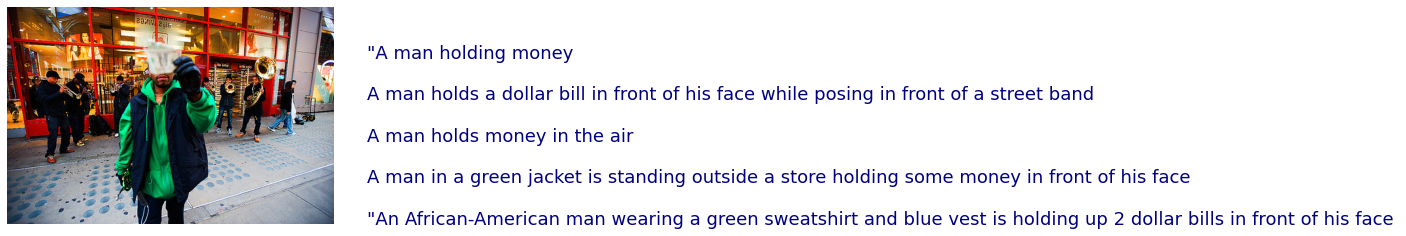

In [17]:
def caption_with_img_plot(image_id, frame) :
  #get the captions
  capt = ("\n" *2).join(frame[frame['ID'] == image_id].Captions.to_list())
  fig, ax = plt.subplots()
  ax.set_axis_off()
  idx = df.ID.to_list().index(image_id)
  im =  Image.open(df.Path.iloc[idx])
  w, h = im.size[0], im.size[-1]
  ax.imshow(im)
  ax.text(w+50, h, capt, fontsize = 18, color = 'navy')
caption_with_img_plot(df.ID.iloc[8049], df)

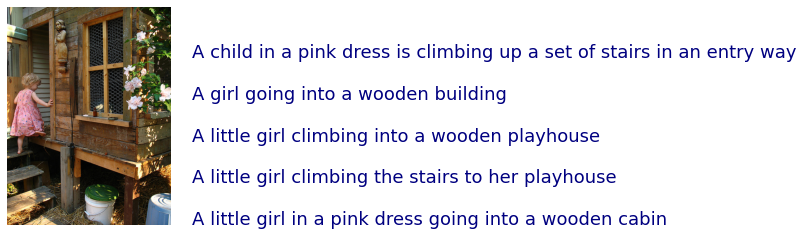

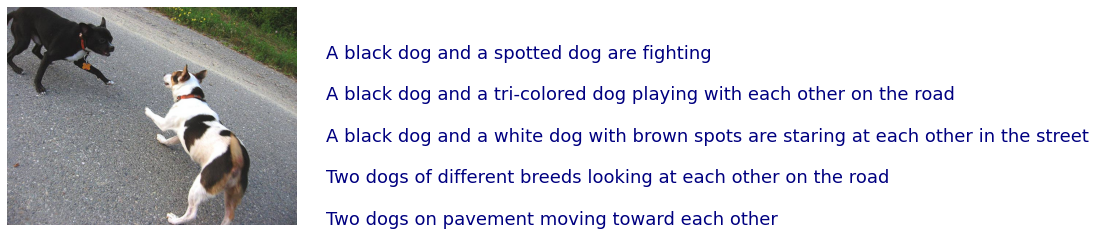

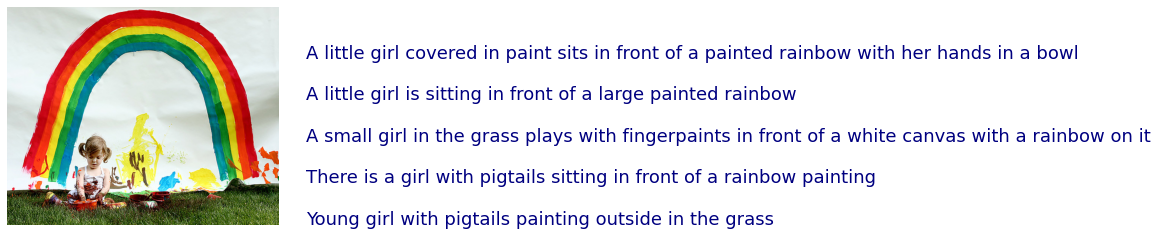

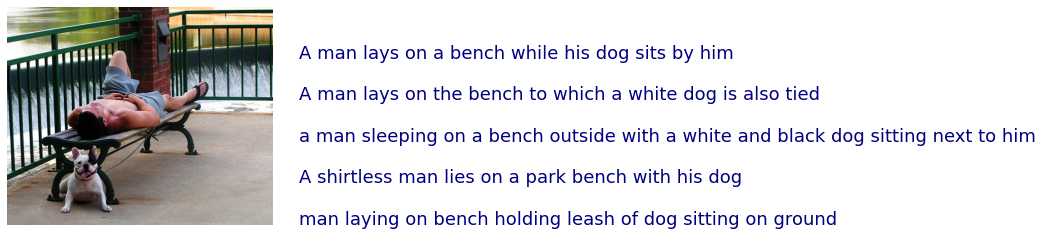

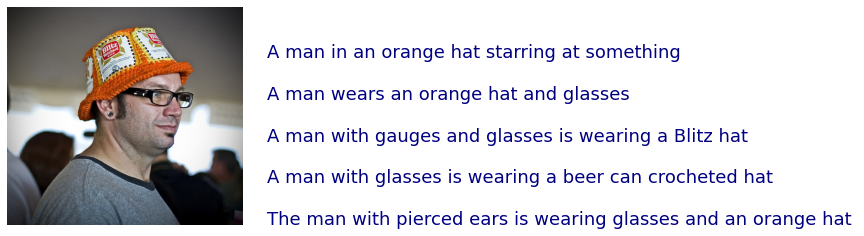

In [18]:
def execute_img_capt(start, end, frame) :
  for r in range(start, end) :
    caption_with_img_plot(frame.ID.drop_duplicates().iloc[r], frame)

execute_img_capt(0, 5, df)  

In [19]:
#data cleaning
rem_punct = str.maketrans('', '', string.punctuation)
for r in range(len(annotations)) :
  line = annotations[r]
  line = line.split()

  # converting to lowercase
  line = [word.lower() for word in line]

  # remove punctuation from each caption and hanging letters
  line = [word.translate(rem_punct) for word in line]
  line = [word for word in line if len(word) > 1]

  # remove numeric values
  line = [word for word in line if word.isalpha()]

  annotations[r] = ' '.join(line)


In [20]:
#add the <start> & <end> token to all those captions as well
annotations = ['<start>' + ' ' + line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_vector

In [21]:
##list contatining captions for an image
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [22]:
# create the tokenizer

#your code here

top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = 'UNK')

In [23]:
# Create word-to-index and index-to-word mappings.

#your code here

tokenizer.fit_on_texts(annotations)

#transform each text into a sequence of integers
train_seqs = tokenizer.texts_to_sequences(annotations)

In [24]:
# we add PAD token for zero

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [25]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [26]:
tokenizer.index_word

{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [27]:
# Create a word count of your tokenizer to visualize the Top 30 occuring words after text processing

#your code here
tokenizer_top_words = [word for line in annotations for word in line.split() ]

#tokenizer_top_words_count
tokenizer_top_words_count = collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

Counter({'<start>': 40455,
         'child': 1517,
         'in': 18182,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6496,
         'stairs': 109,
         'an': 2358,
         'entry': 1,
         'way': 48,
         '<end>': 40455,
         'girl': 3284,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1750,
         'playhouse': 6,
         'the': 17676,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3627,
         'dog': 7956,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tricolored': 12,
         'playing': 1954,
         'with': 7308,
         'each': 399,
         'other': 667,
         'on': 10367,
         'road': 380,
         'white': 3710,
         'brown': 2471,
         'spots': 28,
         'staring': 57,
      

<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


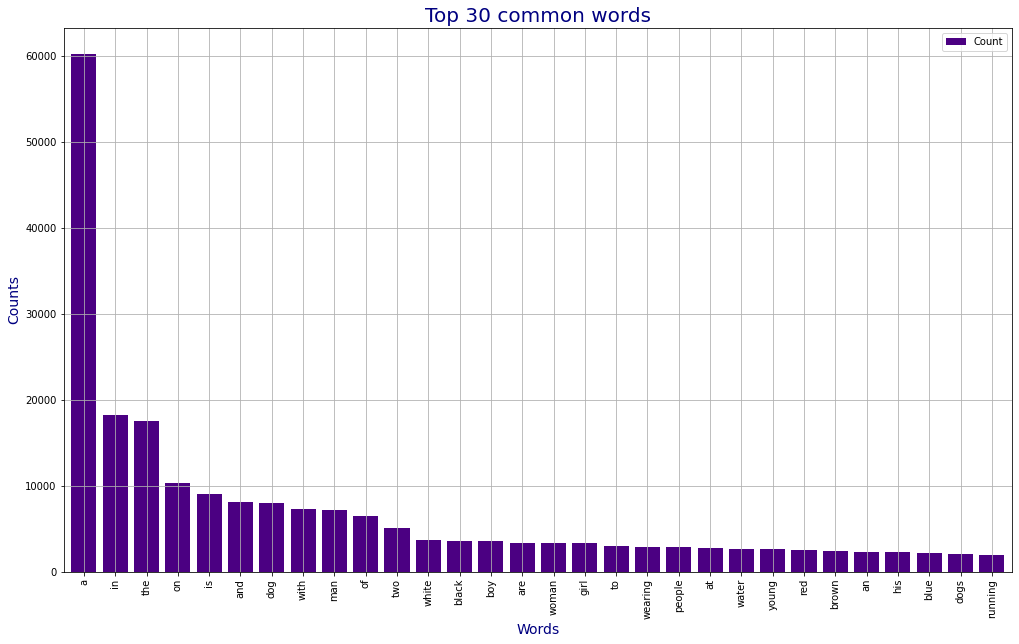

In [28]:
for word, count in tokenizer_top_words_count.most_common(30) :
  print(word, ": ", count)

tokens = tokenizer_top_words_count.most_common(30)
most_com_words_df = pd.DataFrame(tokens, columns = ['Word', 'Count'])

#plot 30 most common words
most_common_words_df.plot.bar(x = 'Word', y= 'Count', width=0.8, color = 'indigo', figsize = (17, 10))
plt.title('Top 30 common words', fontsize =20, color= 'navy')
plt.xlabel('Words', fontsize =14, color= 'navy')
plt.ylabel('Counts', fontsize =14, color= 'navy')
plt.grid(b=None)

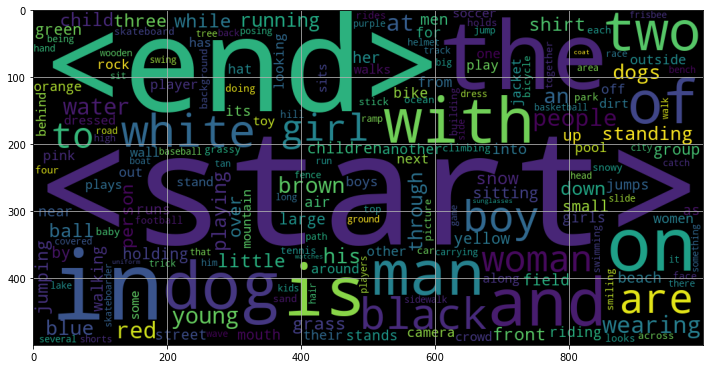

In [29]:
wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(tokenizer_top_words_count)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud_token)
plt.grid(b = None)

In [30]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

#store the length of all lists
train_seqs_len = [len(seq) for seq in train_seqs]

#store elements from list with maximum value
longest_word_length = max(train_seqs_len)

#calculate longest word_length and pads all sequences to equal length as that of the longest.
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 31)


In [31]:
# creating list to store preprocessed images and setting up the Image Shape

preprocessed_image = []
IMAGE_SHAPE = (299, 299)

In [32]:
#checking image format 

tf.keras.backend.image_data_format()


'channels_last'

In [33]:
#write your code here for creating the function. This function should return images & their path

#write your pre-processing steps here (checking only for the first five images here)
for img in all_imgs[0:5] :
    img = tf.io.read_file(img, name=None)

    # we need to decode jpeg encoded images (here by default channels = 0)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    #append preprocessed images to the list
    preprocessed_image.append(img)


Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)


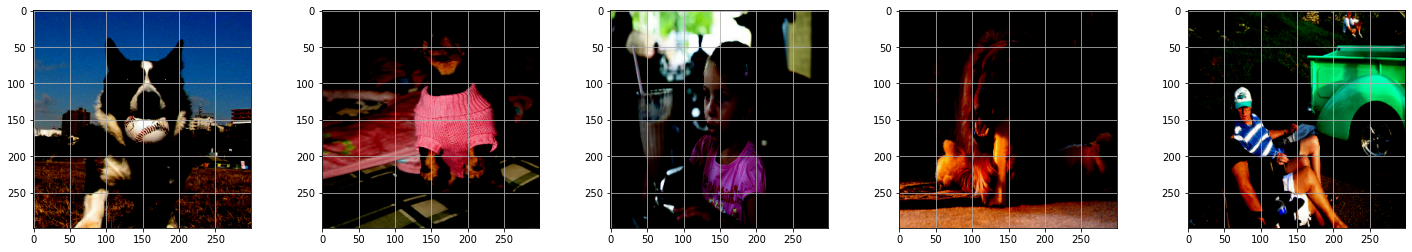

In [34]:
# checking first five images post preprocessing

Display_Images = preprocessed_image[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)

for ax, image in zip(axes, Display_Images) :
  print('Shape after resize : ', image.shape)
  ax.imshow(image)
  ax.grid('off')


In [35]:
## write your code here for applying the function to the image path dataset,
## such that the transformed dataset should contain images & their path


def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=0)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [36]:
all_img_vector

['drive/MyDrive/datascience/archive/Images/1000268201_693b08cb0e.jpg',
 'drive/MyDrive/datascience/archive/Images/1000268201_693b08cb0e.jpg',
 'drive/MyDrive/datascience/archive/Images/1000268201_693b08cb0e.jpg',
 'drive/MyDrive/datascience/archive/Images/1000268201_693b08cb0e.jpg',
 'drive/MyDrive/datascience/archive/Images/1000268201_693b08cb0e.jpg',
 'drive/MyDrive/datascience/archive/Images/1001773457_577c3a7d70.jpg',
 'drive/MyDrive/datascience/archive/Images/1001773457_577c3a7d70.jpg',
 'drive/MyDrive/datascience/archive/Images/1001773457_577c3a7d70.jpg',
 'drive/MyDrive/datascience/archive/Images/1001773457_577c3a7d70.jpg',
 'drive/MyDrive/datascience/archive/Images/1001773457_577c3a7d70.jpg',
 'drive/MyDrive/datascience/archive/Images/1002674143_1b742ab4b8.jpg',
 'drive/MyDrive/datascience/archive/Images/1002674143_1b742ab4b8.jpg',
 'drive/MyDrive/datascience/archive/Images/1002674143_1b742ab4b8.jpg',
 'drive/MyDrive/datascience/archive/Images/1002674143_1b742ab4b8.jpg',
 'driv

In [37]:
# Map each image full path to the function, in order to preprocess the image

## sort the unique paths and store in a list
training_list = sorted(set(all_img_vector))

#create a new dataset from above training list
New_Img = tf.data.Dataset.from_tensor_slices(training_list)

#map load_images function across the elements of the new dataset above
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
#Note  : Here, num_parallel_calls = tf.data.experimental.AUTOTUNE sets the number of parallel calls dynamically.
            ## based on the current GPU/CPU

#setting a batch size of 64
New_Img = New_Img.batch(64, drop_remainder=False)
#Note : As we don't want to drop the last batch if it contains less than 64 elements, we set drop_remainder to false

In [38]:
New_Img

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [39]:
#Ratio = 80:20 and we will set random state = 42

path_train, path_test, caption_train, caption_test = train_test_split(all_img_vector, cap_vector, test_size = 0.2, random_state = 42)

In [40]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [41]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output  #write code here to get the output of the image_model

#build the final model using both input & output layer
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 1s 0us/step


In [42]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [43]:
# extract features from each image in the dataset

img_features = {}
for image, image_path in tqdm(New_Img) :
  # we are using tqdm for progress bar

  # feed images from newly created Dataset above to Inception V3 built above
  batch_features = image_features_extract_model(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 127/127 [02:40<00:00,  1.26s/it]


In [44]:
batch_features

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.74351358e-02, 0.00000000e+00, ...,
          2.31988579e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.07821807e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.93859771e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.85819179e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.42442790e-02, 0.00000000e+00, 5.05764186e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.23049003e-01, 1.36132035e-02, ...,
          2.33802810e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

In [45]:
batch_features_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 7.7435136e-02, 0.0000000e+00, ...,
         2.3198858e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0782181e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9385977e-01, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.8581918e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.6569097e+00, 0.0000000e+00],
        [0.0000000e+00, 4.0248823e-01, 0.0000000e+00, ...,
         0.0000000e+00, 3.1789857e-01, 0.0000000e+00],
        [0.0000000e+00, 2.5347097e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2504921e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 7.8731775e-02, ...,
         1.2063218e+00, 0.0000000e+00, 0.0000000e+00],
        [0.000000

In [46]:
len(img_features)

8091

In [47]:
batch_feat.shape

TensorShape([64, 2048])

In [48]:
#view top five items of img_features dict
import more_itertools
top_5 = more_itertools.take(5, img_features.items())

top_5

[('drive/MyDrive/datascience/archive/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.16971648],
         [0.        , 0.        , 1.0106382 , ..., 0.        , 0.        ,
          0.06092738],
         ...,
         [0.        , 0.        , 2.0379    , ..., 1.2030529 , 0.        ,
          1.9924941 ],
         [0.        , 0.        , 0.90467036, ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2528872 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('drive/MyDrive/datascience/archive/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.663776  , 0.46306023, ..., 0.        , 0.        ,
          3.332227  ],
         [0.        , 1.2268733 , 0.        , ..., 0.        , 0.25400886,
          3.329479  ],
         [1.2884222 , 1.519688  , 0.    

In [49]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    
    # your code goes here to create the dataset & transform it
    
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [50]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):
    
    # your code goes here to create the dataset & transform it
    
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    # dataset created using tf.data.Dataset.from_tensor_slices
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
     
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    # .prefetch() is used to prepare all upcoming elements, while current elements are being processed
    # We set reshuffle_each_iteration set to True in order to ensure different order per epoch
    # Also,  drop_remainder is set to False as we don't want to miss out any element if the last batch contains less than 64 elements

    return data

In [51]:
train_dataset = gen_dataset(path_train,caption_train)
test_dataset = gen_dataset(path_test,caption_test)

In [52]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 31)


In [53]:
# Setting  parameters

embedding_dim = 256 
units = 512

#top 5,000 words +1
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE  #len(total test images) // BATCH_SIZE

max_length = 31
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [54]:
tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [55]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [56]:
encoder=Encoder(embedding_dim)

In [57]:
from keras.utils.vis_utils import plot_model
#plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [58]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)

        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = hidden[:, tf.newaxis]

        # build your score funciton to shape: (batch_size, 8*8, units)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  

        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 

        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features 

        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        
        return context_vector, attention_weights

In [59]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [60]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [61]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


In [62]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object

In [63]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [64]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [65]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [66]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        encoder_op = encoder(img_tensor)

        #apply teacher forcing by passing target word as next input to the decoder
        for r in range(1, target.shape[1]) :
          #pass encoder_op to decoder
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) # calculating gradient wrt each trainable var

    #we will now compute the gradients and apply it to the optimizer while backpropagating
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [67]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size = target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)

      #apply teacher forcing again
      for r in range(1, target.shape[1]) :
        #pass encoder_op to decoder
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)

        dec_input = tf.expand_dims(target[: , r], 1)

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) # calculating gradient wrt each trainable var

    #we will now compute the gradients and apply it to the optimizer while backpropagating
    optimizer.apply_gradients(zip(grad, trainable_vars))                      


    return loss, avg_loss

In [68]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [69]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [02:48<39:23, 168.82s/it]

For epoch: 1, the train loss is 1.437, & test loss is 1.201
Time taken for 1 epoch 168.6332335472107 sec

Test loss has been reduced from 100.000 to 1.201


 13%|█▎        | 2/15 [03:54<23:28, 108.35s/it]

For epoch: 2, the train loss is 1.109, & test loss is 1.059
Time taken for 1 epoch 65.87665486335754 sec

Test loss has been reduced from 1.201 to 1.059


 20%|██        | 3/15 [05:00<17:45, 88.76s/it] 

For epoch: 3, the train loss is 1.007, & test loss is 0.973
Time taken for 1 epoch 65.31456565856934 sec

Test loss has been reduced from 1.059 to 0.973


 27%|██▋       | 4/15 [06:05<14:35, 79.58s/it]

For epoch: 4, the train loss is 0.935, & test loss is 0.908
Time taken for 1 epoch 65.3572793006897 sec

Test loss has been reduced from 0.973 to 0.908


 33%|███▎      | 5/15 [07:11<12:25, 74.54s/it]

For epoch: 5, the train loss is 0.875, & test loss is 0.854
Time taken for 1 epoch 65.4698235988617 sec

Test loss has been reduced from 0.908 to 0.854


 40%|████      | 6/15 [08:17<10:43, 71.51s/it]

For epoch: 6, the train loss is 0.823, & test loss is 0.801
Time taken for 1 epoch 65.47897982597351 sec

Test loss has been reduced from 0.854 to 0.801


 47%|████▋     | 7/15 [09:22<09:17, 69.65s/it]

For epoch: 7, the train loss is 0.776, & test loss is 0.755
Time taken for 1 epoch 65.64644289016724 sec

Test loss has been reduced from 0.801 to 0.755


 53%|█████▎    | 8/15 [10:28<07:58, 68.36s/it]

For epoch: 8, the train loss is 0.731, & test loss is 0.713
Time taken for 1 epoch 65.46644735336304 sec

Test loss has been reduced from 0.755 to 0.713


 60%|██████    | 9/15 [11:33<06:44, 67.47s/it]

For epoch: 9, the train loss is 0.690, & test loss is 0.672
Time taken for 1 epoch 65.35223436355591 sec

Test loss has been reduced from 0.713 to 0.672


 67%|██████▋   | 10/15 [12:39<05:34, 66.84s/it]

For epoch: 10, the train loss is 0.652, & test loss is 0.635
Time taken for 1 epoch 65.2979986667633 sec

Test loss has been reduced from 0.672 to 0.635


 73%|███████▎  | 11/15 [13:44<04:25, 66.42s/it]

For epoch: 11, the train loss is 0.617, & test loss is 0.602
Time taken for 1 epoch 65.29669666290283 sec

Test loss has been reduced from 0.635 to 0.602


 80%|████████  | 12/15 [14:50<03:18, 66.11s/it]

For epoch: 12, the train loss is 0.584, & test loss is 0.568
Time taken for 1 epoch 65.260169506073 sec

Test loss has been reduced from 0.602 to 0.568


 87%|████████▋ | 13/15 [15:55<02:11, 65.90s/it]

For epoch: 13, the train loss is 0.554, & test loss is 0.539
Time taken for 1 epoch 65.25322532653809 sec

Test loss has been reduced from 0.568 to 0.539


 93%|█████████▎| 14/15 [17:00<01:05, 65.73s/it]

For epoch: 14, the train loss is 0.526, & test loss is 0.511
Time taken for 1 epoch 65.19385123252869 sec

Test loss has been reduced from 0.539 to 0.511


100%|██████████| 15/15 [18:06<00:00, 72.43s/it]

For epoch: 15, the train loss is 0.499, & test loss is 0.487
Time taken for 1 epoch 65.28584003448486 sec

Test loss has been reduced from 0.511 to 0.487


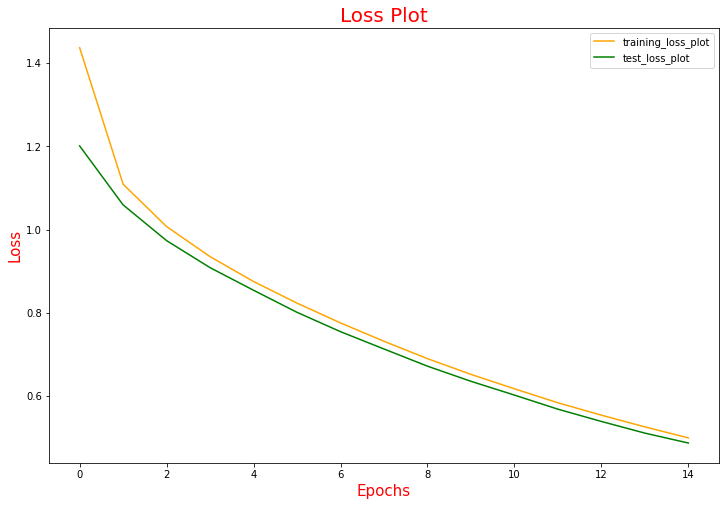

In [70]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()


In [71]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [72]:
def plot_attention_map (caption, weights, image) :

  fig = plt.figure(figsize = (10, 10))
  temp_img = np.array(Image.open(image))

  cap_len = len(caption)
  for cap in range(cap_len) :
    weights_img = np.reshape(weights[cap], (8,8))
    wweights_img = np.array(Image.fromarray(weights_img).resize((224,224), Image.LANCZOS))

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap], fontsize = 14, color = 'red')

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [73]:
from nltk.translate.bleu_score import sentence_bleu

In [74]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [75]:
image_test = path_test.copy()

In [86]:
def pred_caption_audio(random, autoplay=False, weights=(0.5, 0.5, 0, 0)) :

    cap_test_data = caption_test.copy()
    rid = np.random.randint(0, random)
    test_image = image_test[rid]
    # test_image = 'drive/MyDrive/datascience/nos_photos/'
    # real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)      


    pred_caption=' '.join(result).rsplit(' ', 1)[0]


    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BELU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attention_map(result, attention_plot, test_image)

    # we will make use of Google Text to Speech API (online), which will convert the caption to audio
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image
    



# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 1</p>

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 27.25230591784881
Real Caption: the two men and their bikes are on the side of snowy road
Prediction Caption: two men on bicycles down snowy road


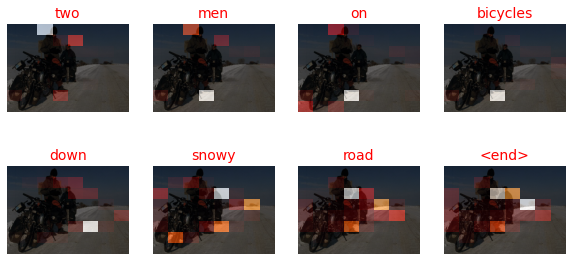

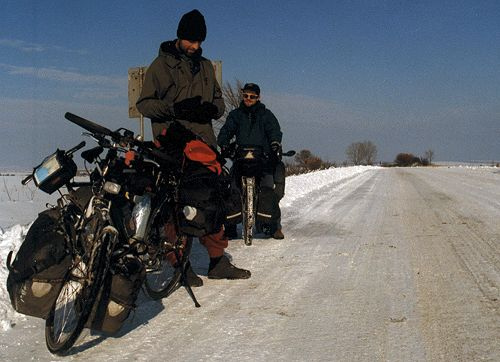

In [88]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 38.60973950960897
Real Caption: skier is falling into the snow
Prediction Caption: person is falling down steep hill


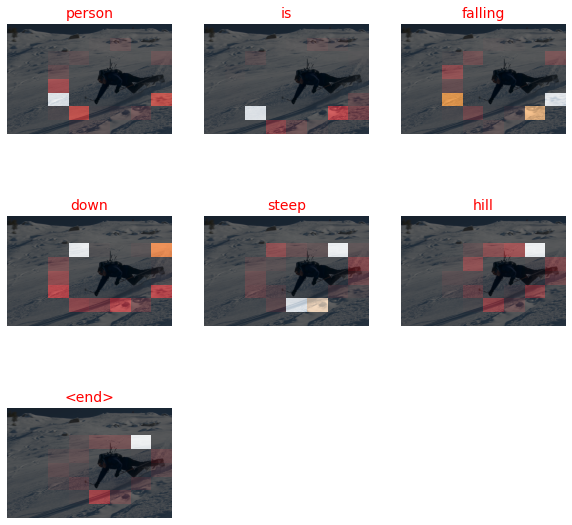

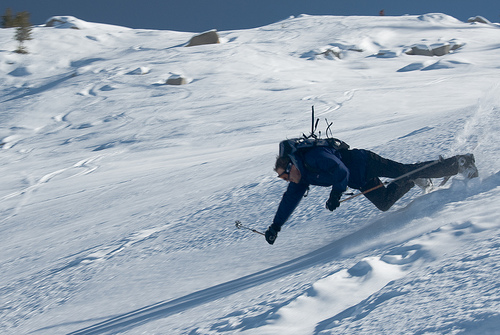

In [89]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

### WOW!! 100% accuracy as indicated by BLEU Score

# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 2</p>

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 15.387898494891994
Real Caption: man in an orange jacket raising his hands to the sky in the sand
Prediction Caption: man is standing on the sand dune


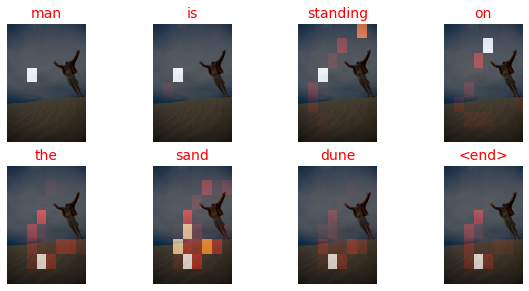

In [90]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 3</p>

BELU score: 55.26188533079546
Real Caption: yellow lab jumping up into the air to catch soccer ball
Prediction Caption: the yellow dog jumps up to catch soccer ball


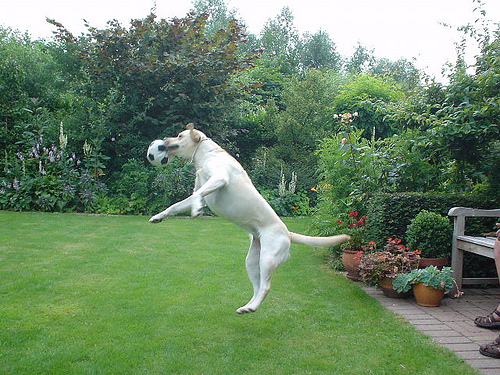

In [91]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

#### 100% accuracy yet again! So this combination of weights actually work better than others.

# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 4</p>

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

BELU score: 6.180901090099428e-76
Real Caption: child UNK confetti in woman hair
Prediction Caption: young girl dumps confetti onto lady head


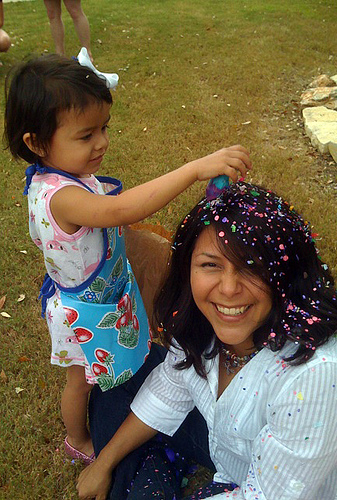

In [92]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.35, 0.25, 0, 0))
Image.open(test_image)

# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 5</p>

BELU score: 56.47181220077593
Real Caption: black and white spotted dog is UNK gray and white dog
Prediction Caption: black and white spotted dog is UNK


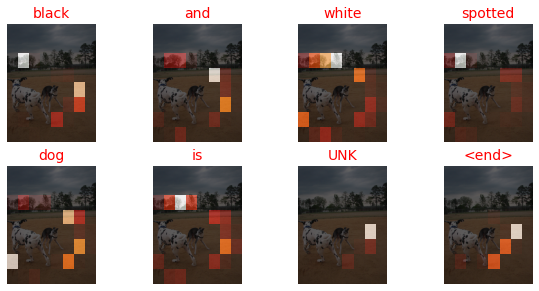

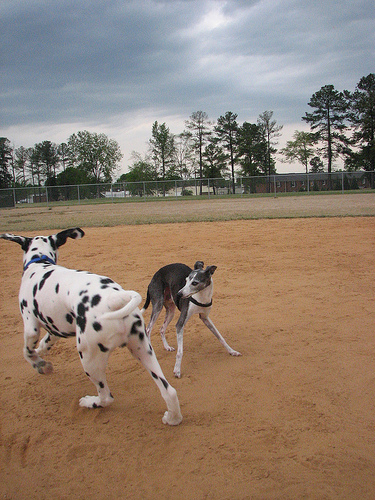

In [93]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.5, 0, 0))
Image.open(test_image)

# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 6</p>

BELU score: 31.61337205741664
Real Caption: child stoops to pick up watermelon from large pile of them
Prediction Caption: small child stoops to pick up watermelon from stone painted on flat flat flat flat flat flat flat flat flat flat flat flat flat flat flat flat flat flat flat


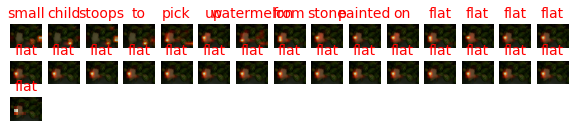

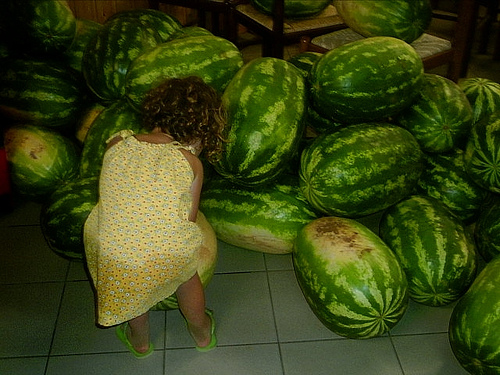

In [94]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.25, 0.5, 0, 0))
Image.open(test_image)

# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 7</p>

In [95]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.25, 0.25, 0, 0))
Image.open(test_image)

BELU score: 85.45740127924681
Real Caption: black dog and white dog are wrestling on the ground
Prediction Caption: black dog and black dog are wrestling on the grass


# <p style="background-color:white;font-family:seoge print;color:slateblue ;font-size:100%;text-align:left;border-radius:20px 60px;">Test Image 8</p>

In [96]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.25, 0.5, 0, 0))
Image.open(test_image)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

BELU score: 1.9051753265014662e-153
Real Caption: guy in white trying to score in soccer while being blocked by two guys in orange and black
Prediction Caption: man in red falls for the ball



<a id="9"></a>
# <p style="background-color:slateblue;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 60px;">Conclusion</p>


### 1. We experimented with multiple other weights (12-15 different combinations) but found the best results mainly for the below :

    1. (0.5, 0.5 , 0, 0)
    
    2. (0.5, 0.25 , 0, 0)
    
    3. (0.25, 0.25 , 0, 0)
    
    4. (0.25, 0.35 , 0, 0)
    
 > The probability of getting a **lower Bleu (less than 50%) score was least for the above weights.**
 
 > We achieved **more than 70% accuracy for majority of the test images using above weights.**
 
 > We also got an **accuracy of 100%  multiple time using weights : (0.5, 0.5 , 0, 0), (0.5, 0.25, 0, 0) and (0.25, 0.5, 0, 0)**
 
 
 ### 2. We used Inception V3 Model with pretrained weights (Imagenet), for CNN (to extract feature vectors) 
 
    1. Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset
     
     2. The model is the culmination of many ideas developed by multiple researchers over the years.
     
     3. The model itself is made up of symmetric and asymmetric building blocks, including convolutions, average pooling, max pooling, concatinations, dropouts, and fully connected layers. 
     
     4. Batch normalization is used extensively throughout the model and applied to activation inputs. Loss is computed using Softmax.
     
### 3. GRU has been used here for the Decoder (RNN)

    1. Attention Model has also been used in Decoder to ensure higher focus on relevant and particular parts of the image at a given timestamp, rather than focussing on entire image.
    
    2. This ensured a higher accuracy, reduced noise and faster computation.
    
    3. The output from the decoder - i.e predicted caption and  hidden state, is fed back to the model and predictions were used to calculate the loss.
    
    4. We used cross entropy - SparseCategoricalCrossentropy to calculate the loss.
    
    5. We also made use of Teacher forcing to decide the next input to the decoder. It ensured faster convergence and a reliably stable model.
    
 ### 4. Model Training and  Evaluation
 
     1. We trained the model in 15 EPOCHS and the final loss got reduced to 0.482.
     
     2. We chose not to use further epochs as the intent here was not to create the state of art model. Rather understand how to integrate attention mechanism with E-D architecture for images.
 
 
     3. Prediction of Captions is done through calculating the probabilities of a specific word in the vocabulary.
     
     4. We made use of Greedy Search to calculate the probability of words as per their occurrence in the given vocabulary list. It outputs the word with the highest probability.
     
     6. We made use of BLUE Score to evaluate our model performance and accuracy. Higher the BLUE score, better the model performance.
     
     7. We tested the model with different combinations of weights and achieve the max Bleu Score (100%) for several combinations.
     
     
 
 ----------------------------------------------------------

![](https://voximplant.com/assets/images/2020/07/03/speech-to-text.png)